In [2]:
# import numpy as np
import jax.numpy as np

import matplotlib.pyplot as plt
from rk_integrate import rk_integrate
from deathrate import a
%load_ext line_profiler


%load_ext autoreload
%autoreload 2

def better_imshow(row_vals, col_vals, data, ax=None):
    #row_vals and col_vals are the data that was swept over
    assert len(row_vals) == data.shape[0], 'length of row_vals does not match shape of data'
    assert len(col_vals) == data.shape[1], 'length of col_vals does not match shape of data'
    if ax == None:
        plt.imshow(data, origin='lower', extent=[col_vals[0], col_vals[-1], row_vals[0], row_vals[-1]], aspect='auto')
    else:
        ax.imshow(data, origin='lower', extent=[col_vals[0], col_vals[-1], row_vals[0], row_vals[-1]], aspect='auto')

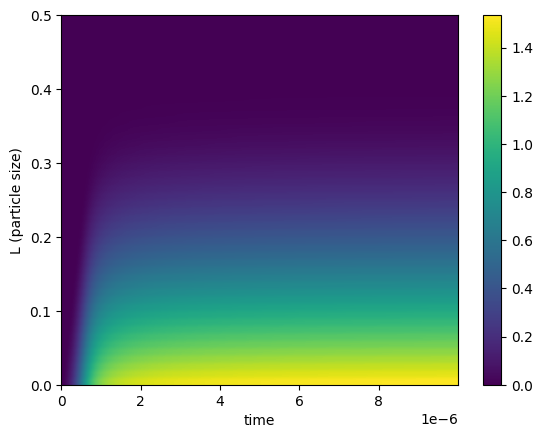

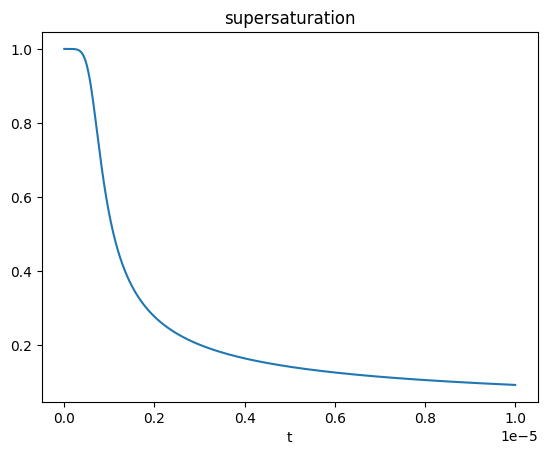

Text(0.5, 0, 't')

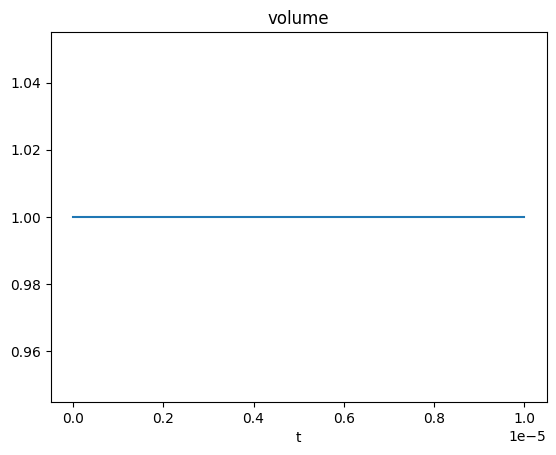

In [3]:
L_list = np.linspace(0,0.5, 50)  # uniform dL assumed below
tlist = np.linspace(0,1e-5,1000) 
# tlist = np.linspace(0,1e-6,100) 


S0 = 1 #initial supersaturation
V0 = 1 #initial volume
n0 = np.zeros_like(L_list) #initial population density distribution

L_matrix = np.tile(L_list, (len(L_list),1))
for i in range(len(L_list)):
     # L_matrix[i,:i] = 0
     L_matrix = L_matrix.at[i,:i].set(0)
        
a_L_list = a(L_list)
a_L_matrix = a(L_matrix)

B0 = np.zeros_like(L_list)  # nucleation birth matrix
# B0[0] = 1
B0 = B0.at[0].set(1)

#parameters, plus some precomuted arraays
p = {"L_list" : L_list, #discretization bins
     "L_matrix" : L_matrix,
     "a_L_list" : a_L_list,
     "a_L_matrix" : a_L_matrix,
     "dL" : L_list[1]-L_list[0],
     "B0" : B0,
     'E' :  1e-7, #evaporation rate
     'V' : 1e-3, #solvent volume
     'rho' : 1200, # density of the crystal
     'k_v' : 1, #goes in N_C, volumetric shape factor
     'k_g' : 1e6, #growth rate constant m/s
     'g' : 3, #power constant for growth
     'k_N' : 1e5, #nucleation rate constant 
     'alpha' :5, #power constant for nucleation
     'Breakage': True #toggle breakage for debug
     }


#integrate the equations
x0 = np.hstack([S0, V0, n0])
from evalf import evalf
from dndt import calc_dndt
from birthrate import crystal_birth_breakage, crystal_birth_nucleation
from deathrate import a
# %lprun -f evalf -f calc_dndt -f crystal_birth_breakage -f crystal_birth_nucleation x_t = rk_integrate(x0, t_vec = tlist, p = p) 

x_t = rk_integrate(x0, t_vec = tlist, p = p) 

#plot results
n_t = x_t[:,2:]
better_imshow(L_list, tlist, n_t.T)
plt.ylabel('L (particle size)')
plt.xlabel('time')
plt.colorbar()
plt.show()

plt.plot(tlist, x_t[:,0]) 
plt.title('supersaturation')
plt.xlabel('t')
plt.show()

plt.plot(tlist, x_t[:,1]) 
plt.title('volume')
plt.xlabel('t')

In [6]:
# let's try getting gradient wrt parameters
from jax import grad

""" params
'E' :  1e-7, #evaporation rate
'V' : 1e-3, #solvent volume
'rho' : 1200, # density of the crystal
'k_v' : 1, #goes in N_C, volumetric shape factor
'k_g' : 1e6, #growth rate constant m/s
'g' : 3, #power constant for growth
'k_N' : 1e5, #nucleation rate constant 
'alpha' :5, #power constant for nucleation
"""
     
pvec = np.array([1e-7, 1e-3, 1200, 1, 1e6, 3, 1e5, 5])

def f(pvec):
    L_list = np.linspace(0,0.5, 50)  # uniform dL assumed below
    # tlist = np.linspace(0,1e-5,1000) 
    tlist = np.linspace(0,1e-6,100) 

    S0 = 1 #initial supersaturation
    V0 = 1 #initial volume
    n0 = np.zeros_like(L_list) #initial population density distribution

    L_matrix = np.tile(L_list, (len(L_list),1))
    for i in range(len(L_list)):
        # L_matrix[i,:i] = 0
        L_matrix = L_matrix.at[i ,:i].set(0)
            
    a_L_list = a(L_list)
    a_L_matrix = a(L_matrix)

    B0 = np.zeros_like(L_list)  # nucleation birth matrix
    # B0[0] = 1
    B0 = B0.at[0].set(1)


    p = {"L_list" : L_list, #discretization bins
     "L_matrix" : L_matrix,
     "a_L_list" : a_L_list,
     "a_L_matrix" : a_L_matrix,
     "dL" : L_list[1]-L_list[0],
     "B0" : B0,
     'E' :  pvec[0], #evaporation rate
     'V' : pvec[1], #solvent volume
     'rho' : pvec[2], # density of the crystal
     'k_v' : pvec[3], #goes in N_C, volumetric shape factor
     'k_g' : pvec[4], #growth rate constant m/s
     'g' : pvec[5], #power constant for growth
     'k_N' : pvec[6], #nucleation rate constant 
     'alpha' :pvec[7], #power constant for nucleation
     'Breakage': True #toggle breakage for debug
     }
    x0 = np.hstack([S0, V0, n0])
    x_t = rk_integrate(x0, t_vec = tlist, p = p) 
    return np.linalg.norm(x_t[:,2:])

In [7]:
f(pvec)

Array(19.56434, dtype=float32)

In [97]:
grad(f)(pvec)

Array([ 2.2373224e-05,  0.0000000e+00, -3.7665493e-03, -4.5198593e+00,
        6.2246836e-06, -1.1707995e+00,  1.5044207e-04, -9.2452325e-02],      dtype=float32)

<function __main__.f(pvec)>

In [30]:
evalf(x0, p)

Array([ 1.e-07, -1.e-07,  1.e+05,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00], dtype=float32)

In [29]:
l = p["L_list"]

In [41]:
L_matrix = np.tile(L_list, (len(L_list),1))

In [42]:
for i in range(len(L_list)):
    L_matrix[i,:i] = 0

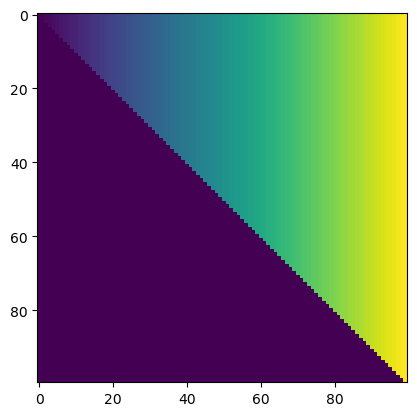

In [44]:
plt.imshow(L_matrix)

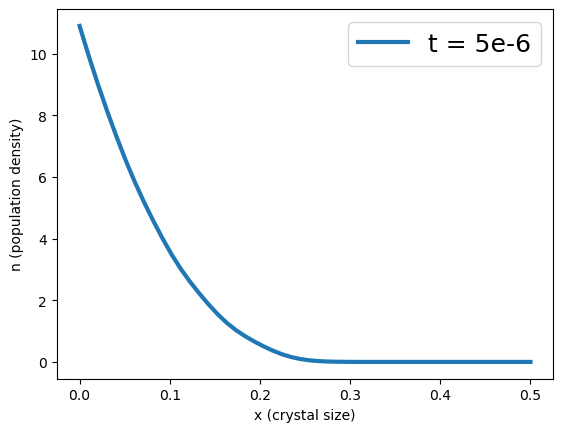

In [18]:
#plot results
n_t = x_t[999,2:]
plt.figure(figsize=[6.4,4.8])
ax1 = plt.gca()
ax1.plot(L_list, n_t, linewidth = 3, label =r't = 5e-6')
#ax1.plot(L_list, x_t[500,2:], linewidth = 3, label =r't = 5e-6')

#ax1.set_xlim([0, 10])
#ax1.set_ylim([0, 6])
ax1.set_ylabel("n (population density)")
ax1.set_xlabel("x (crystal size)")
ax1.legend(prop={'size': 18}) 


In [32]:
dt_list = np.logspace(-9, -7, 15)
x_final_list = []
for dt in dt_list: 
    tlist = np.arange(0, 1e-5, dt)
    #integrate
    x_t = euler(x0, t_vec = tlist, p = p) 
    x_final_list.append(x_t[-1,2:])
    

Text(0.5, 0, '$\\Delta t$')

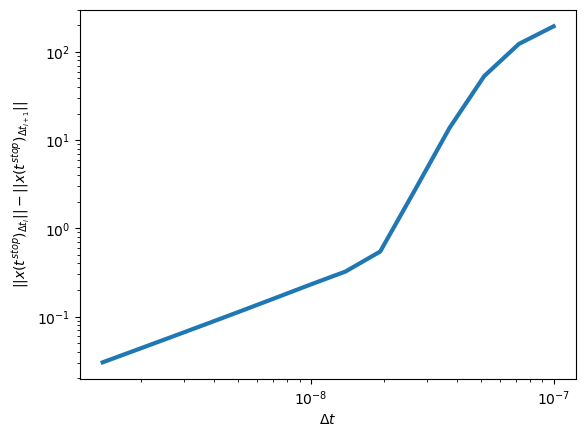

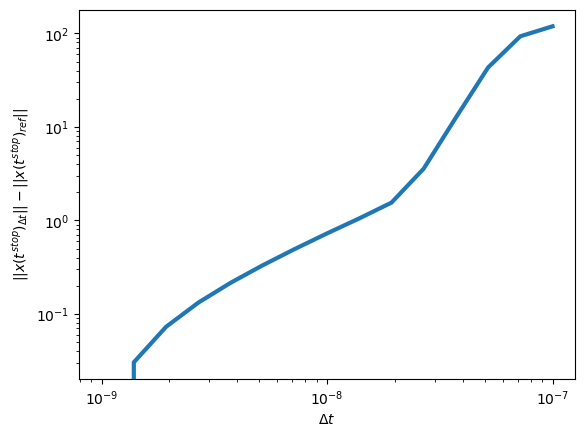

In [43]:
x_ref = x_final_list[0]
error_ref = []
error_successive = []
for i in range(len(dt_list)):
    error_ref.append(np.linalg.norm(x_final_list[i] - x_ref, ord= np.inf))
for i in range(len(dt_list)-1):
    error_successive.append(np.linalg.norm(x_final_list[i] - x_final_list[i+1], ord= np.inf))


plt.figure(figsize=[6.4,4.8])
ax1 = plt.gca()
ax1.loglog(dt_list[1:], error_successive, linewidth = 3)
ax1.set_ylabel(r"$||x(t^{stop})_{\Delta t_{i}}|| - ||x(t^{stop})_{\Delta t_{i + 1}}||$")
ax1.set_xlabel(r"$\Delta t$")

plt.figure(figsize=[6.4,4.8])
ax1 = plt.gca()
ax1.loglog(dt_list, error_ref, linewidth = 3)
ax1.set_ylabel(r"$||x(t^{stop})_{\Delta t}|| - ||x(t^{stop})_{ref}||$")
ax1.set_xlabel(r"$\Delta t$")

In [ ]:
#also check relative error (compared to norm(n))